# DSCI-598 Capstone
## Maryville University
### November - December 2023
### Alison Hawke

## Initial models: Logistic Regression, Logistic Regression with Cross Validation, Decision Tree, and Random Forest

## Loading required libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

## Loading the data set

In [2]:
train = pd.read_csv('/kaggle/input/forest-cover-type-prediction/train.csv', dtype = str)
train.shape

(15120, 56)

In [3]:
test = pd.read_csv('/kaggle/input/forest-cover-type-prediction/test.csv', dtype = str)
test.shape

(565892, 55)

### Numeric and categorical data in the training set

In [4]:
X_num_train = train.loc[:, ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                   'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                   'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']].values
X_cat_train = train.loc[:, ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 
                      'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 
                      'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 
                      'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 
                      'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 
                      'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
                      'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
                      'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
                      'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
                      'Soil_Type40',]].values
y = train.loc[:, 'Cover_Type'].values

print('Numerical Feature Array Shape:   ', X_num_train.shape)
print('Categorical Feature Array Shape: ', X_cat_train.shape)
print('Label Array Shape:               ', y.shape)

Numerical Feature Array Shape:    (15120, 10)
Categorical Feature Array Shape:  (15120, 44)
Label Array Shape:                (15120,)


In [5]:
# join arrays
X = np.hstack((X_num_train, X_cat_train))

print('Feature Array Shape:', X.shape)

Feature Array Shape: (15120, 54)


### Splitting the train.csv data into model training and test sets

In [6]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size = 0.2, random_state = 1, stratify = y_hold)

# Logistic regression model

* Validation Accuracy:  66.6%
* Test set accuracy: 68%

This model is a basic approach, and has some success at predicting the test set.

In [7]:
%%time

lr_mod = LogisticRegression(solver = 'lbfgs', penalty = None, max_iter = 10000)
lr_mod.fit(X_train, y_train)

lr_mod_train_acc = lr_mod.score(X_train, y_train)
lr_mod_valid_acc = lr_mod.score(X_valid, y_valid)

print('Training Accuracy:   ', round(lr_mod_train_acc, 4))
print('Validation Accuracy: ', round(lr_mod_valid_acc, 4))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy:    0.6661
Validation Accuracy:  0.666
CPU times: user 4min 4s, sys: 2min 7s, total: 6min 12s
Wall time: 1min 36s


### Logistic regression model confusion matrix

In [8]:
y_pred = lr_mod.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cnf_matrix, columns = ['1', '2', '3', '4', '5', '6', '7'])
cm_df.index = ['1', '2', '3', '4', '5', '6', '7']
cm_df

,1,2,3,4,5,6,7
1,52,16,0,0,4,0,14
2,18,45,1,0,18,2,2
3,0,0,39,13,7,27,0
4,0,0,7,72,0,8,0
5,2,12,0,0,71,1,1
6,0,0,14,10,4,59,0
7,11,0,0,0,0,0,75


### Logistic regression model classification report

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.60      0.62        86
           2       0.62      0.52      0.57        86
           3       0.64      0.45      0.53        86
           4       0.76      0.83      0.79        87
           5       0.68      0.82      0.74        87
           6       0.61      0.68      0.64        87
           7       0.82      0.87      0.84        86

    accuracy                           0.68       605
   macro avg       0.68      0.68      0.68       605
weighted avg       0.68      0.68      0.68       605



Cover types 4 and 7 are easiest for the logistic regression model to predict. The overall accuracy score is 68%.

# Logistic regression with cross validation

* Validation Accuracy:  66.93%
* Test set accuracy: 70%

In [10]:
%%time

# Set parameters for LogisticRegressionCV
n_folds = 10
C_values = [0.001, 0.01, 0.05, 0.1, 1.0, 100.0]

cv_lr_mod = LogisticRegressionCV(Cs = C_values, cv = n_folds, penalty = 'l2', 
                           refit = True, solver = 'liblinear', 
                           random_state = 0, fit_intercept = False)

cv_lr_mod.fit(X_train, y_train)

cv_lr_mod_train_acc = cv_lr_mod.score(X_train, y_train)
cv_lr_mod_valid_acc = cv_lr_mod.score(X_valid, y_valid)

print('Training Accuracy:   ', round(cv_lr_mod_train_acc, 4))
print('Validation Accuracy: ', round(cv_lr_mod_valid_acc, 4))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy:    0.667
Validation Accuracy:  0.6693
CPU times: user 2min 16s, sys: 16.1 s, total: 2min 32s
Wall time: 2min 5s


In [11]:
y_pred = cv_lr_mod.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cnf_matrix, columns = ['1', '2', '3', '4', '5', '6', '7'])
cm_df.index = ['1', '2', '3', '4', '5', '6', '7']
cm_df

,1,2,3,4,5,6,7
1,59,13,0,0,5,1,8
2,16,50,3,0,16,1,0
3,0,0,43,12,4,27,0
4,0,0,8,75,0,4,0
5,4,11,5,0,63,3,1
6,0,3,13,10,5,56,0
7,7,0,0,0,1,0,78


In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.69      0.69      0.69        86
           2       0.65      0.58      0.61        86
           3       0.60      0.50      0.54        86
           4       0.77      0.86      0.82        87
           5       0.67      0.72      0.70        87
           6       0.61      0.64      0.63        87
           7       0.90      0.91      0.90        86

    accuracy                           0.70       605
   macro avg       0.70      0.70      0.70       605
weighted avg       0.70      0.70      0.70       605



Using cross-validation improved the logistic regresion model to 70% accuracy.

# Decision tree model

* Training Accuracy for Optimal Model: 0.9497
* Validation Accuracy for Optimal Model: 0.7933

In [13]:
%%time

dt_train_acc = []
dt_valid_acc = []
depth_range = range(2, 30)

for d in depth_range:
    np.random.seed(1)
    temp_tree = DecisionTreeClassifier(max_depth = d)
    temp_tree.fit(X_train, y_train)
    dt_train_acc.append(temp_tree.score(X_train, y_train))
    dt_valid_acc.append(temp_tree.score(X_valid, y_valid))

dt_idx = np.argmax(dt_valid_acc)
dt_opt_depth = depth_range[dt_idx]

print('Decision tree model:')
print('Optimal value for max_depth:           ', dt_opt_depth)
print('Training Accuracy for Optimal Model:   ', round(dt_train_acc[dt_idx], 4))
print('Validation Accuracy for Optimal Model: ', round(dt_valid_acc[dt_idx], 4))

Decision tree model:
Optimal value for max_depth:            15
Training Accuracy for Optimal Model:    0.9497
Validation Accuracy for Optimal Model:  0.7933
CPU times: user 12.4 s, sys: 5.53 ms, total: 12.4 s
Wall time: 12.4 s


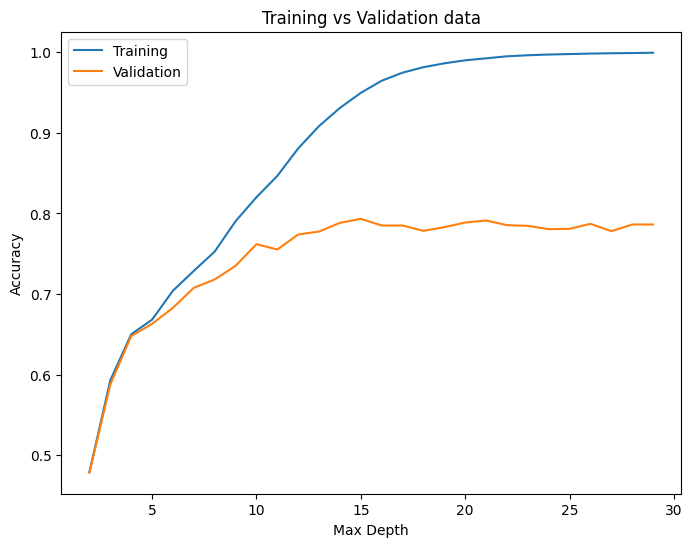

In [14]:
plt.figure(figsize = [8, 6])

plt.plot(depth_range, dt_train_acc, label = 'Training')
plt.plot(depth_range, dt_valid_acc, label = 'Validation')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Validation data')
plt.legend()
plt.show()

The decision tree shows a marked improvement in accuracy over the logistic regression model, with a validation accuracy of 79.33%.

# Random Forest model

* Training Accuracy for Optimal Model:    0.9999
* Validation Accuracy for Optimal Model:  0.8623

In [15]:
%%time

rf_train_acc = []
rf_valid_acc = []
depth_range = range(2, 30)
np.random.seed(1)

for d in depth_range:
    temp_forest = RandomForestClassifier(n_estimators = 100, max_depth = d)
    temp_forest.fit(X_train, y_train)
    rf_train_acc.append(temp_forest.score(X_train, y_train))
    rf_valid_acc.append(temp_forest.score(X_valid, y_valid))

rf_idx = np.argmax(rf_valid_acc)
rf_opt_depth = depth_range[rf_idx]

print('Random Forest model:')
print('Optimal value for max_depth:           ', rf_opt_depth)
print('Training Accuracy for Optimal Model:   ', round(rf_train_acc[rf_idx], 4))
print('Validation Accuracy for Optimal Model: ', round(rf_valid_acc[rf_idx], 4))

Random Forest model:
Optimal value for max_depth:            29
Training Accuracy for Optimal Model:    1.0
Validation Accuracy for Optimal Model:  0.8648
CPU times: user 1min 12s, sys: 357 ms, total: 1min 12s
Wall time: 1min 13s


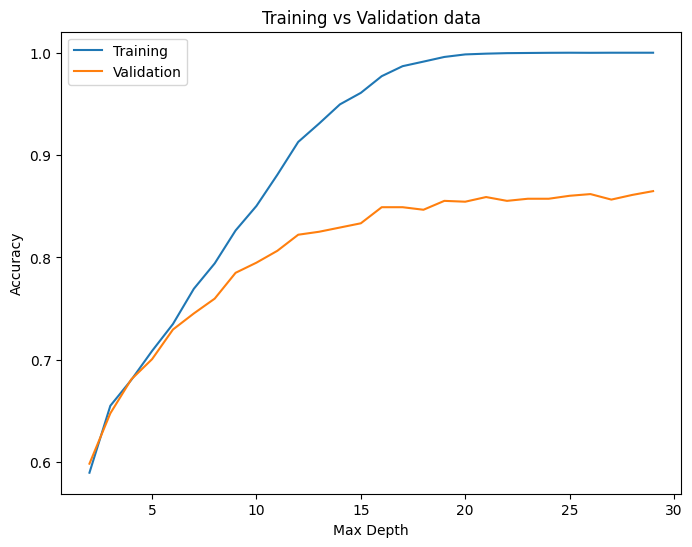

In [16]:
plt.figure(figsize = [8, 6])

plt.plot(depth_range, rf_train_acc, label = 'Training')
plt.plot(depth_range, rf_valid_acc, label = 'Validation')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Validation data')
plt.legend()
plt.show()

The random forest model is an improvement over the decision tree, taking the validation accuracy to 86.48%

# Best random forest model

* Training Accuracy:    0.9999
* Validation Accuracy:  0.8623

In [17]:
%%time

best_rf_train_acc = []
best_rf_valid_acc = []

np.random.seed(1)
best_forest = RandomForestClassifier(n_estimators = 100, max_depth = 25)
best_forest.fit(X_train, y_train)

best_rf_train_acc.append(best_forest.score(X_train, y_train))
best_rf_valid_acc.append(best_forest.score(X_valid, y_valid))

CPU times: user 3.27 s, sys: 33.9 ms, total: 3.31 s
Wall time: 3.31 s


In [18]:
print('Best random forest model:')
print('Training Accuracy:   ', round(best_rf_train_acc[0], 4))
print('Validation Accuracy: ', round(best_rf_valid_acc[0], 4))

Best random forest model:
Training Accuracy:    0.9999
Validation Accuracy:  0.8623


# Predicting the test set

Having selected a model type, the random forest model can now be trained on the training set, and create predictions for the test set for submission to the Kaggle competition.

In [19]:
X_num_test = test.loc[:, ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                   'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                   'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']].values
X_cat_test = test.loc[:, ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 
                      'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 
                      'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 
                      'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 
                      'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 
                      'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
                      'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
                      'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
                      'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
                      'Soil_Type40',]].values

In [20]:
%%time

X_test = np.hstack((X_num_test, X_cat_test))
y_pred = best_forest.predict(X_test)

CPU times: user 15.1 s, sys: 487 ms, total: 15.6 s
Wall time: 15.6 s


# Submission

Score: 0.73306

On submission to Kaggle, the random forest model scored an accuracy of 73%, a drop from the validation accuracy of 86%.

In [21]:
Id = np.asarray(pd.read_csv('/kaggle/input/forest-cover-type-prediction/test.csv')['Id'])

print(f'Id: ', Id.shape)
print('y_pred: ', y_pred.shape)

submission = pd.DataFrame({'Id':Id, 'Cover_Type':y_pred})
submission.to_csv('submission.csv', header = True, index = False)

Id:  (565892,)
y_pred:  (565892,)
